# Genetic Programming

This chapter introduces some very basic concepts about Genetic Programming. As usual, we will require a couple of imports:

In [1]:
import random
import sys
import re
import matplotlib.pyplot as plt
from statistics import mean

## Classic Genetic Programming

The main difference between regular Genetic Algorithms and Genetic Programming lies in the representation: GAs tend to operate on the genotype, while GPs operate on the phenotype (programs); for this, the programs are traditionally represented as trees. Furthermore, GPs have a more open-ended nature in that the number of elements used in a solution as well as their interconnections must be open to evolution.

In a tree representation, programs are typically generated using two sets: A set of terminals (items of arity 0) and functions (items of arity > 0). The input to a function must be the result of any other function that can be defined, which leads to the important property of _type closure_: Each function must be able to handle all values it might ever receive as input, all terminals must be allowable inputs for all functions, and the output from any function must be a permitted input to any other function. 

The first step to evolving a suitable program for a given problem is thus to define the sets of functions and terminals:

In [2]:
def add(x, y): return x + y
def sub(x, y): return x - y
def mul(x, y): return x * y
def div(x, y): return 1 if not y else x/y

In [3]:
FUNCTIONS = [add, sub, mul, div]
TERMINALS = ['A', 'B', 'C', 'D']

### Initialisation

Our usual approach to define the presentation is by introducing code that creates random instances. Let's do the same here, except that this time we need to use a tree representation. For this, we define a suitable datastructure:

In [4]:
class Node:
    
    def __init__(self, data=None, left=None, right=None):
        self.data = data
        self.left = left
        self.right = right

    def __str__(self):
        if self.data in FUNCTIONS:
            return self.data.__name__
        else:
            return str(self.data)
        
    def to_dot(self, dot):
        dot.node(str(id(self)), str(self))
        
        if self.left:
            left_dot = self.left.to_dot(dot)
            dot.edge(str(id(self)), str(id(self.left)))

        if self.right:
            right_dot = self.right.to_dot(dot)
            dot.edge(str(id(self)), str(id(self.right)))

        return dot      

The `to_dot` function is a helper function we will use in order to represent trees visually using GraphViz (which will need to be installed on your machine if you want to run this Jupyter notebook).

In [5]:
from graphviz import Digraph

In [6]:
def print_tree(tree):
    dot = Digraph()
    tree.to_dot(dot)
    return dot

#### Full Initialisation

A basic approach to creating random trees is to grow full trees. We decide on a maximum depth for our tree, and then add non-terminal nodes until the depth limit is reached. Once we have reached it, we only add terminals as leaves. 

In [7]:
MAX_DEPTH = 3

In [8]:
def get_random_terminal():
    return random.choice(TERMINALS)

In [9]:
def get_random_function():
    return random.choice(FUNCTIONS)

In [10]:
def fill_random_tree(depth=0):
    tree = Node()
    if depth < MAX_DEPTH:
        tree.data = get_random_function()
        tree.left  = fill_random_tree(depth + 1)
        tree.right = fill_random_tree(depth + 1)
    else:
        tree.data = get_random_terminal()
    return tree

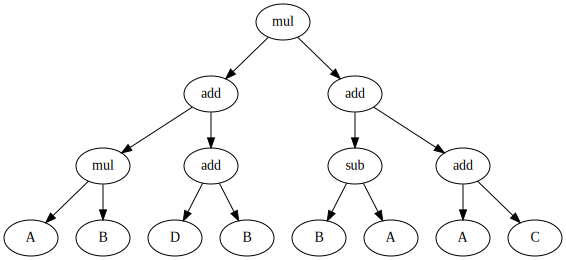

In [11]:
root = fill_random_tree()
print_tree(root)

#### Grow Initialisation

An alternative approach to filling entire trees up to their maximum depth is to grow trees of various sizes. For this we add random nodes while we haven't reached the depth limit. The resulting trees will be less bushy, but the ratio between terminals and non-terminals will bias the average size. 

In [12]:
def grow_random_tree(depth=0):
    tree = Node()
    if depth >= MAX_DEPTH or random.random() > 0.5:
        tree.data = get_random_terminal()
    else:
        tree.data = get_random_function()
        tree.left  = grow_random_tree(depth + 1)
        tree.right = grow_random_tree(depth + 1)
    return tree

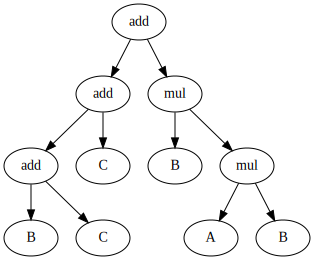

In [13]:
root = grow_random_tree()
print_tree(root)

If the ratio of terminals to functions is high, then we might end up with many trees of size 1. To avoid this, we can define a minimum depth for the trees we want to generate, and only consider terminals once the minimum size has been reached:

In [14]:
MIN_DEPTH = 2

In [15]:
def grow_random_tree(depth=0):
    tree = Node()
    if depth < MIN_DEPTH:
        tree.data = get_random_function()
    elif depth >= MAX_DEPTH:
        tree.data =  get_random_terminal()
    else:
        if random.random() > 0.5:
            tree.data =  get_random_terminal()
        else:
            tree.data = get_random_function()
                
    if tree.data in FUNCTIONS:
        tree.left  = grow_random_tree(depth + 1)
        tree.right = grow_random_tree(depth + 1)
        
    return tree

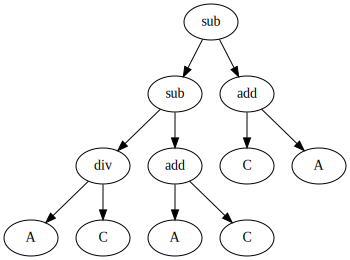

In [16]:
root = grow_random_tree()
print_tree(root)

#### Ramped Half and Half

A common practice when creating the initial population is use a mix of filled and grown trees. For example, half the population may be initialised with the full method, and half with the grow method.

In [17]:
population_size = 40

In [18]:
def get_initial_population():
    population = []
    while len(population) < population_size:
        if random.random() < 0.5:
            population.append(fill_random_tree())
        else:
            population.append(grow_random_tree())
        
    return population

 Sometimes this is also done using a ramped approach, to generate trees of various sizes:

In [19]:
def get_initial_population():
    population = []
    stages = MAX_DEPTH - MIN_DEPTH + 1
    for stage in range(MIN_DEPTH, MAX_DEPTH + 1):
        for md in range(int(population_size/stages/2)):
            population.append(grow_random_tree(MAX_DEPTH - stage))
        for md in range(int(population_size/stages/2)):
            population.append(fill_random_tree(MAX_DEPTH - stage))
    return population

By defining a helper function that calculates the size of a tree, we can look at the distribution of tree sizes:

In [20]:
def size(tree):
    if tree.data in FUNCTIONS:
        l = size(tree.left) if tree.left else 0
        r = size(tree.right) if tree.right else 0
        return 1 + l + r
    else:
        return 1

(array([ 6.,  4.,  0., 10.,  0.,  1.,  2.,  0.,  6., 11.]),
 array([ 3. ,  4.2,  5.4,  6.6,  7.8,  9. , 10.2, 11.4, 12.6, 13.8, 15. ]),
 <BarContainer object of 10 artists>)

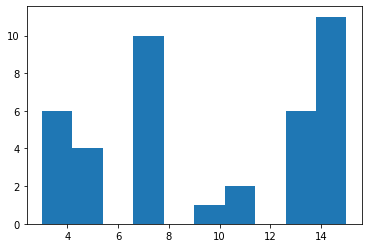

In [21]:
plt.hist([size(x) for x in get_initial_population()])

### Ephemeral Random Constants

Our terminals only include constants (`A` etc), but in practice we might also need actual values, such as numbers. Including all possible numbers in the set of terminals does not scale well. A common approach is therefore to include _ephemeral random constants_: A single terminal represents the choice of a random value; when the terminal is chosen then it is instantiated with an actual random value:

In [22]:
EPHEMERAL_CONSTANT = "R"
TERMINALS = ['A', 'B', 'C', 'D', EPHEMERAL_CONSTANT]
EPHEMERAL_RANGE = 5

In [23]:
def get_random_terminal():
    t = random.choice(TERMINALS)
    if t == EPHEMERAL_CONSTANT:
        t = random.randint(-EPHEMERAL_RANGE, EPHEMERAL_RANGE)
    return t

### Search Operators

Since we have a different representation to what we used in the past (which was mainly list-based), we need to adapt our search operators.

#### Crossover

A basic approach to crossing over two trees is to randomly choose two crossover points in the parent trees, and then to cut and swap subtrees below the crossover points. We first need a function with which we can create copies of trees:

In [24]:
def copy(tree):
    t = Node()
    t.data = tree.data
    if tree.left:  t.left = copy(tree.left)
    if tree.right: t.right = copy(tree.right)
    return t 

We need a couple further helper functions in order to find subtrees at chosen crossover points. First, here's a helper class that allows us to count up or down while (hackily) traversing a tree:

In [25]:
class Counter:
    def __init__(self, num):
        self.num = num
    
    def reduce(self):
        self.num -= 1
        
    def increase(self):
        self.num += 1
    
    def is_target(self):
        return self.num == 0
    
    def greater_zero(self):
        return self.num > 0
    
    def get_value(self):
        return self.num

Using this helper class, we can now traverse the tree and return a copy of the subtree whenever the counter has reached the target:

In [26]:
def get_subtree_at(tree, counter):
    counter.reduce()
    if counter.is_target():
        return copy(tree)
    else:
        ret = None
        if tree.left and counter.greater_zero(): 
            ret = get_subtree_at(tree.left, counter)
        if not ret and tree.right and counter.greater_zero(): 
            ret = get_subtree_at(tree.right, counter)
        return ret

Similarly, we can replace a target node with an entirely different subtree given a counter that tells us when we've reached the target node:

In [27]:
def insert_subtree_at(tree, subtree, counter):
    counter.reduce()
    if counter.is_target():
        tree.data  = subtree.data
        tree.left  = subtree.left
        tree.right = subtree.right
    else:
        if tree.left and counter.greater_zero(): 
            insert_subtree_at(tree.left, subtree, counter)
        if tree.right and counter.greater_zero(): 
            insert_subtree_at(tree.right, subtree, counter)

Using these two functions we can now define a simple crossover function that picks a random subtree from one parent (`parent1`) and inserts it at a random position in the other parent (`parent2`):

In [28]:
def subtree_crossover(parent1, parent2):
    pos1 = random.randint(1, size(parent1))
    pos2 = random.randint(1, size(parent2))
    
    if size(parent1) == 1:
        subtree = copy(parent1)
    else:
        subtree = get_subtree_at(parent1, Counter(pos1))
    offspring = copy(parent2)
    insert_subtree_at(offspring, subtree, Counter(pos2))
    
    return offspring

Let's create some example parents to cross over:

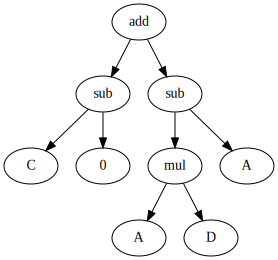

In [29]:
parent1 = grow_random_tree()
print_tree(parent1)

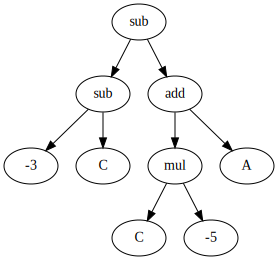

In [30]:
parent2 = grow_random_tree()
print_tree(parent2)

Now we can produce an offspring by calling our `crossover` function with these two parents:

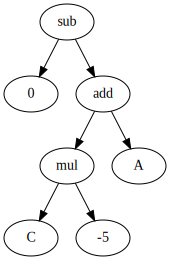

In [31]:
offspring = subtree_crossover(parent1, parent2)
print_tree(offspring)

Often crossover points are not actually sampled with a uniform random distribution though: Given a tree with branching factor 2 or more, the majority of nodes will be leaves, which crossover will mostly cut a single leaf. A common alternative is to apply a 90% probability of choosing a function node, and only a 10% chance of choosing a terminal node.

#### Mutation

Subtree mutation (a.k.a. headless chicken mutation) is a simple mutation where we pick a random subtree, and replace it with a randomly generated subtree:

In [32]:
P_mutate = 0.1

In [33]:
def subtree_mutation(tree):
    mutation_point = random.randint(1, size(tree))
    random_subtree = grow_random_tree(MAX_DEPTH - 2)
    insert_subtree_at(tree, random_subtree, Counter(mutation_point))

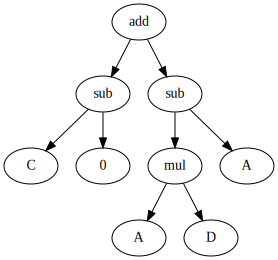

In [34]:
print_tree(parent1)

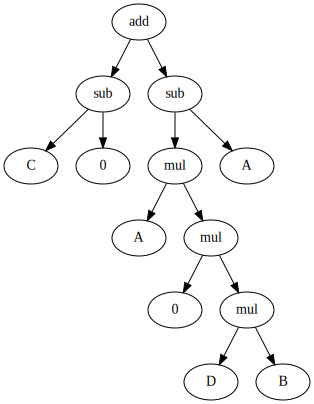

In [35]:
offspring = copy(parent1)
subtree_mutation(offspring)
print_tree(offspring)

An alternative mutation operator is _point mutation_ where, for each node, we replace the node with a certain probability with another node of the same arity.

In [36]:
def point_mutation(tree):
    if random.random() < P_mutate:
        if tree.data in FUNCTIONS: 
            tree.data = random.choice(FUNCTIONS)
        else:
            tree.data = get_random_terminal()
    
    if tree.left:
        point_mutation(tree.left)
    if tree.right:
        point_mutation(tree.right)

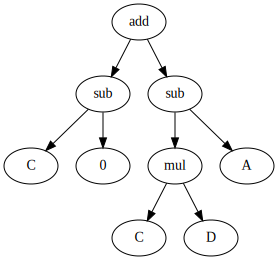

In [37]:
offspring = copy(parent1)
point_mutation(offspring)
print_tree(offspring)

#### Selection

Since selection is independent of the representation, we don't need any adaptation. Since we use a variable size representation, we will include the size as one of the selection criteria.

In [38]:
tournament_size = 3
def tournament_selection(population):
    candidates = random.sample(population, tournament_size)        
    winner = min(candidates, key=lambda x: (get_fitness(x), size(x)))
    return winner

An evolution step of our GA now just needs to integrate these operators:

In [39]:
def evolution_step(population):
    new_population = []
    while len(new_population) < len(population):
        parent1 = copy(selection(population))
        parent2 = copy(selection(population))

        if random.random() < P_xover:
            offspring = crossover(parent1, parent2)
        else:
            offspring = random.choice([parent1, parent2])

        if random.random() < 0.5:
            point_mutation(offspring)
        else:
            subtree_mutation(offspring)

        new_population.append(offspring)

    population.clear()
    population.extend(new_population)

    best_fitness = min([get_fitness(k) for k in population])
    return best_fitness

Similarly, the overall GA is also the same as always:

In [40]:
fitness_values = []
size_values = []

In [41]:
def ga():
    population = get_initial_population()
    best_fitness = sys.maxsize
    for p in population:
        fitness = get_fitness(p)
        if fitness < best_fitness or (fitness == best_fitness and size(p) < size(best_solution)):
            best_fitness = fitness
            best_solution = copy(p)

    iteration = 0
    while iteration < max_iterations and best_fitness > 0.000001:
        fitness_values.append(best_fitness)
        size_values.append(mean([size(x) for x in population]))
        print(f"GA Iteration {iteration}, best fitness: {best_fitness}, average size: {size_values[-1]}")
        iteration += 1
        evolution_step(population)

        for p in population:
            fitness = get_fitness(p)
            if fitness < best_fitness or (fitness == best_fitness and size(p) < size(best_solution)):
                best_fitness = fitness
                best_solution = copy(p)

    print(f"GA solution after {iteration} iterations, best fitness: {best_fitness}")
    return best_solution


### Example Problem: Symbolic Regression

We will use symbolic regression as a first example problem. Given a set of points, we would like to come up with a symbolic expression that represents a function approximating the points. As example equation, we will use $x^2 + x + 1$.

We only have one terminal `x` for this problem, but can also include ephemeral constants:

In [42]:
TERMINALS = ["x", EPHEMERAL_CONSTANT]

As fitness function for how close we are to approximating a set of points we use the sum of absolute errors for all points at different values of `x` in the range [−1.0, +1.0]. Thus, a smaller fitness value is better; a fitness of zero indicates a perfect fit. In order to calculate the error for any given point, we need a helper function that evaluates a tree for a given value of `x`:

In [43]:
def evaluate(tree, assignment):
    if tree.data in FUNCTIONS:
        return tree.data(evaluate(tree.left, assignment), evaluate(tree.right, assignment))
    elif tree.data in assignment:
        return assignment[tree.data]
    else:
        return tree.data

The dictionary `assignment` will map all terminals to actual values during the evaluation. We sample a number of points for measuring the error:

In [44]:
test_data = {}
for value in [x/10 for x in range(-10, 10)]:
    test_data[value] = value*value + value + 1

Now calculating the fitness function reduces to calling the `evaluate` function for each points in our test set, and summing up the differences:

In [45]:
def get_fitness(tree):
    fitness = 0.0
    
    for (x, expected_result) in test_data.items():
        assignment = {}
        assignment["x"] = x
        result = evaluate(tree, assignment)
        fitness += abs(result - expected_result)
    
    return fitness

With this, we can finally call our genetic algorithm:

GA Iteration 0, best fitness: 6.6, average size: 9.55
GA Iteration 1, best fitness: 6.6, average size: 9.15
GA Iteration 2, best fitness: 6.6, average size: 8.15
GA Iteration 3, best fitness: 6.6, average size: 7.75
GA Iteration 4, best fitness: 6.6, average size: 8.2
GA Iteration 5, best fitness: 6.6, average size: 8.4
GA Iteration 6, best fitness: 6.6, average size: 8.95
GA Iteration 7, best fitness: 5.200000000000001, average size: 11.15
GA Iteration 8, best fitness: 5.200000000000001, average size: 14.2
GA Iteration 9, best fitness: 5.200000000000001, average size: 14.5
GA Iteration 10, best fitness: 5.200000000000001, average size: 14.25
GA Iteration 11, best fitness: 5.200000000000001, average size: 16.85
GA Iteration 12, best fitness: 5.200000000000001, average size: 17.4
GA Iteration 13, best fitness: 5.200000000000001, average size: 18.85
GA Iteration 14, best fitness: 5.200000000000001, average size: 22.2
GA Iteration 15, best fitness: 5.200000000000001, average size: 23.1
GA

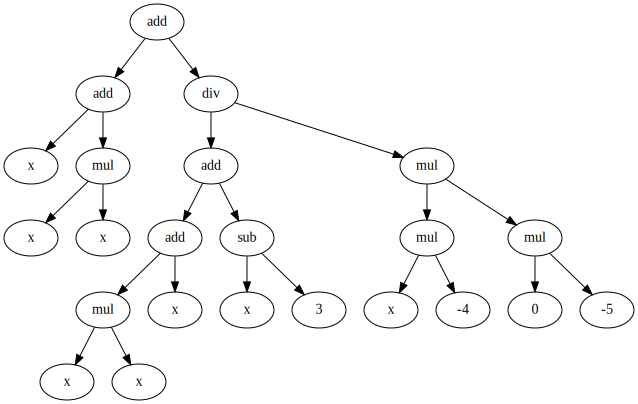

In [46]:
max_iterations = 200
selection = tournament_selection
crossover = subtree_crossover
P_xover = 0.7
fitness_values = []
size_values = []
result = ga()
print_tree(result)

Is the solution actually correct? We can plot the results of this function vs the results of the actual target function to compare:

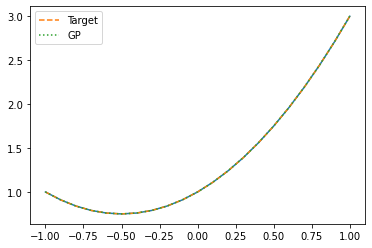

In [47]:
points = [x/10 for x in range(-10, 11)]
real_values = [(x*x + x + 1) for x in points]
gp_values = []
for x in points:
    assignment = {}
    assignment["x"] = x
    gp_values.append(evaluate(result, assignment))
plt.plot(points, gp_values)

plt.plot(points, real_values, linestyle='--', label = "Target")
plt.plot(points, gp_values,  linestyle=':', label = "GP")
plt.legend()

The solution is usually correct; if it is not, try again, and maybe try to adjust the parameters of the GA.

### Handling Bloat

The solution is probably a fairly large tree. Indeed the size is sometimes quite problematic as genetic programming tends to suffer from _bloat_. Let's look at the average population size throughout the evolution:

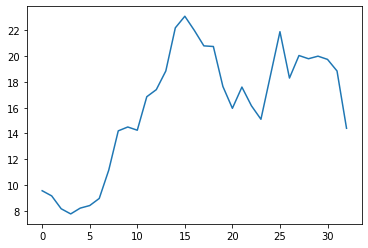

In [48]:
plt.plot(size_values)

We have already adapted our selection operator to counter bloat somewhat, but mutation and crossover also cause an increase in size. We therefore define alternative mutation and crossover operators.

Shrink mutation replaces a random subtree with a terminal node:

In [49]:
def shrink_mutation(individual):
    num_nodes = size(individual)
    if num_nodes < 2:
        return
    
    mutation_point = random.randint(2, num_nodes - 1)
    node = Node()
    node.data = get_random_terminal()
    insert_subtree_at(individual, node, Counter(mutation_point))
    
    return individual

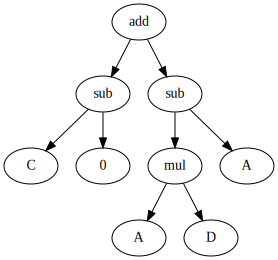

In [50]:
print_tree(parent1)

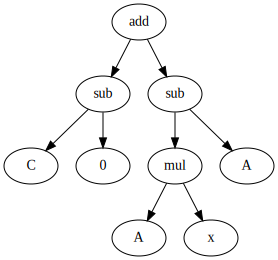

In [51]:
offspring = copy(parent1)
shrink_mutation(offspring)
print_tree(offspring)

Size-fair subtree mutation first picks a random subtree, and then replaces that with a new random subtree that is at most as big as the replaced subtree:

In [52]:
def sizefair_subtree_mutation(tree):
    mutation_point = random.randint(1, size(tree))
    replaced_tree = get_subtree_at(tree, Counter(mutation_point))
    random_subtree = grow_random_tree(MAX_DEPTH - size(replaced_tree))
    
    insert_subtree_at(tree, random_subtree, Counter(mutation_point))

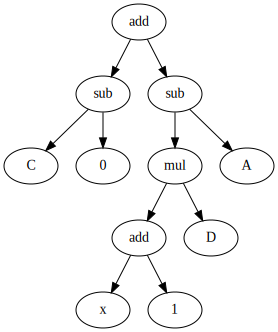

In [53]:
offspring = copy(parent1)
sizefair_subtree_mutation(offspring)
print_tree(offspring)

Permutation mutation shuffles the order of arguments for functions with arity > 1:

In [54]:
def permutation_mutation(tree):
    if random.random() < P_mutate:
        if tree.data in FUNCTIONS: 
            tree.left, tree.right = tree.right, tree.left
    
    if tree.left:
        permutation_mutation(tree.left)
    if tree.right:
        permutation_mutation(tree.right)

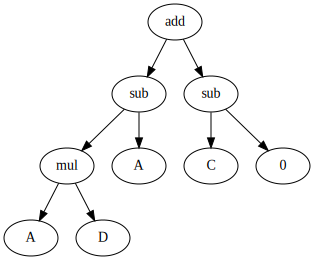

In [55]:
offspring = copy(parent1)
permutation_mutation(offspring)
print_tree(offspring)

There is also a size-fair variant of the crossover operator we defined earlier: We first pick a random crossover point in the first parent. Then, we pick a subtree in the other parent that is not larger than the subtree in the first parent, and perform the crossover with this. We thus define a helper function that gives us all valid positions with subtrees of a maximum size:

In [56]:
def get_smaller_subtree_positions(tree, max_size, positions, counter):
    if size(tree) <= max_size:
        positions.append(counter.get_value())
    counter.increase()
    
    if tree.left:
        get_smaller_subtree_positions(tree.left, max_size, positions, counter)
    if tree.right:
        get_smaller_subtree_positions(tree.right, max_size, positions, counter)

We apply this helper function by simply randomly picking one of the valid positions during crossover:

In [57]:
def sizefair_crossover(parent1, parent2):
    
    # First pick a crossover point in parent1
    pos1 = 1
    if size(parent1) > 1:
        pos1 = random.randint(1, size(parent1) - 1)

    # Then select a subtree that isn't larger than what is being replaced from parent2
    subtree = get_subtree_at(parent1, Counter(pos1))
    subtree_size = size(subtree)    
    positions = []
    get_smaller_subtree_positions(parent2, subtree_size, positions, Counter(1))
    pos2 = random.choice(positions)
    subtree = get_subtree_at(parent2, Counter(pos2))
    
    # Then insert that into parent1
    offspring = copy(parent1)
    insert_subtree_at(offspring, subtree, Counter(pos1))
    
    assert size(offspring) <= size(parent1)
    
    return offspring

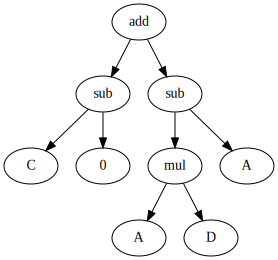

In [58]:
print_tree(parent1)

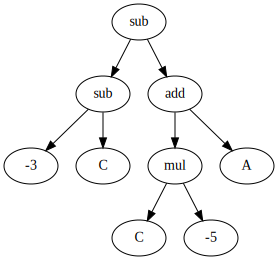

In [59]:
print_tree(parent2)

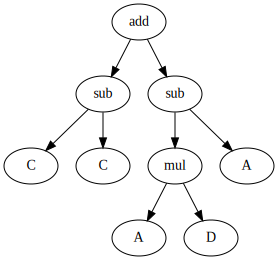

In [60]:
offspring = sizefair_crossover(parent1, parent2)
print_tree(offspring)

Now we just need to do some minor adaptations to make sure that these new operators are actually applied during the evolution:

In [61]:
mutation_operators = [subtree_mutation, permutation_mutation, shrink_mutation, point_mutation, sizefair_subtree_mutation]
crossover = sizefair_crossover

Besides the adapted operators, another common approach is to apply an upper bound on the size, and reject offspring that exceeds that size. This can have negative implications if it is the only means to control bloat, as larger individuals will then become less likely to produce surviving offspring. However, we can use it in conjunction with out optimised operators:

In [62]:
REJECT_SIZE = 50

In [63]:
def evolution_step(population):
    new_population = []
    while len(new_population) < len(population):
        parent1 = copy(selection(population))
        parent2 = copy(selection(population))

        if random.random() < P_xover:
            offspring = crossover(parent1, parent2)
        else:
            offspring = random.choice([parent1, parent2])

        if random.random() < 0.2:
            mutation_operator = random.choice(mutation_operators)
            mutation_operator(offspring)

        if size(offspring) < REJECT_SIZE:
            new_population.append(offspring)

    population.clear()
    population.extend(new_population)

    best_fitness = min([get_fitness(k) for k in population])
    return best_fitness

Thus, finally, let's run the search again for the same target function.

GA Iteration 0, best fitness: 6.700000000000001, average size: 9.44
GA Iteration 1, best fitness: 6.700000000000001, average size: 7.58
GA Iteration 2, best fitness: 6.700000000000001, average size: 6.86
GA Iteration 3, best fitness: 6.700000000000001, average size: 6.94
GA Iteration 4, best fitness: 6.700000000000001, average size: 6.88
GA Iteration 5, best fitness: 6.700000000000001, average size: 5.36
GA Iteration 6, best fitness: 6.700000000000001, average size: 4.16
GA Iteration 7, best fitness: 6.700000000000001, average size: 4.06
GA Iteration 8, best fitness: 6.700000000000001, average size: 3.76
GA Iteration 9, best fitness: 6.700000000000001, average size: 3.88
GA Iteration 10, best fitness: 6.700000000000001, average size: 4
GA Iteration 11, best fitness: 6.700000000000001, average size: 4.08
GA Iteration 12, best fitness: 6.700000000000001, average size: 4.02
GA Iteration 13, best fitness: 6.700000000000001, average size: 3.84
GA Iteration 14, best fitness: 6.7, average siz

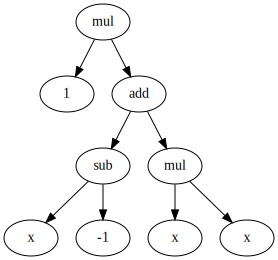

In [64]:
max_iterations = 200
population_size = 100
selection = tournament_selection
crossover = sizefair_crossover
P_xover = 0.7
fitness_values = []
size_values = []
result = ga()
print_tree(result)

To validate whether we are still affected by bloat we can plot the evolution of size again:

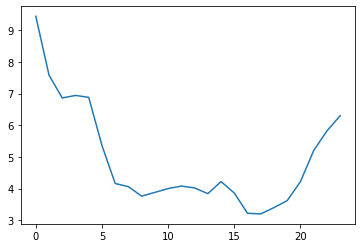

In [65]:
plt.plot(size_values)

We can also compare the resulting function with the desired target function:

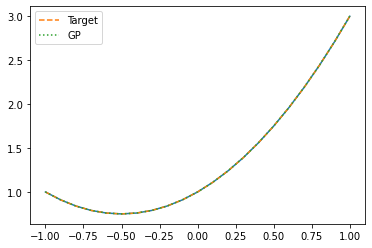

In [66]:
points = [x/10 for x in range(-10, 11)]
real_values = [(x*x + x + 1) for x in points]
gp_values = []
for x in points:
    assignment = {}
    assignment["x"] = x
    gp_values.append(evaluate(result, assignment))
plt.plot(points, gp_values)

plt.plot(points, real_values,  linestyle='--', label = "Target")
plt.plot(points, gp_values,  linestyle=':', label = "GP")
plt.legend()

## Example Application: Fault Localisation

Given a test suite with at least one failing and at least one passing test case, the aim of fault localisation is to identify those statements in a program that are likely faulty. Intuitively, statements that are primarily executed by failed test cases are more likely to be faulty than those that are primarily executed by passed test cases. In spectrum-based fault localisation this is done by evaluating the similarity of each statement with the the error vector (i.e. the vector of pass/fail verdicts for each statement). There are many different competeing similarity metrics (which we will consider in more details the Software Analysis course). 

The basis for this type of fault localisation is a coverage matrix in which we have coverage information for each statement and each test case. We will parse this in the format produced by the GZoltar tool:

In [67]:
def read_matrix(matrix_file, spectra_file, faulty_line):
    line_details = []
    fh = open(spectra_file)
    num_line = 0
    for line in fh:
        num_line += 1
        if num_line == 1:
            continue
        result = line.rstrip()
        line_details.append(result)
    fh.close()

    num_statements = len(line_details)

    ep = {}
    ef = {}
    np = {}
    nf = {}

    for i in range(num_statements):
        ep[i] = 0
        ef[i] = 0
        np[i] = 0
        nf[i] = 0

    fh = open(matrix_file)
    num_test = 0
    for line in fh:
        result = line.split(" ")

        test_result = result[-1].rstrip()
        for i in range(num_statements):
            if result[i] == '1' and test_result == '+':
                ep[i] += 1
            elif result[i] == '1' and test_result == '-':
                ef[i] += 1
            elif result[i] == '0' and test_result == '+':
                np[i] += 1
            elif result[i] == '0' and test_result == '-':
                nf[i] += 1

        num_test += 1
    fh.close()

    return (ep, ef, np, nf, line_details, num_statements, faulty_line)

Our aim is to use GP in order to evolve a similarity function that performs better than the standard metrics. We need some datapoints for our fitness evaluation again; for this we can use some example matrices:

In [68]:
data_files = [('data/fl/matrix.txt', 'data/fl/spectra.csv', 7),
              ('data/fl/matrix-lift.txt', 'data/fl/spectra-lift.csv', 13),
              ('data/fl/matrix-complex.txt', 'data/fl/spectra-complex.csv', 39),
              ('data/fl/matrix-rational.txt', 'data/fl/spectra-rational.csv', 10)
              ]
eval_cases = []

for (matrix, spectrum, faulty_line) in data_files:
    eval_cases.append(read_matrix(matrix, spectrum, faulty_line))

These matrices serve to calculate several factors for each statement:

- $e_f$: Number of times the statement has been executed by failing tests.
- $e_p$: Number of times the statement has been executed by passing tests.
- $n_f$: Number of times the statement has _not_ been executed by failing tests.
- $n_p$: Number of times the statement has _not_ been executed by passing tests.

Based on these factors, different metrics to calculate the suspiciousness of a program statement have been defined, e.g.:

- Tarantula: $\frac{\frac{e_f}{e_f+n_f}}{\frac{e_p}{e_p+n_p} + \frac{e_f}{e_f+n_f}}$
- Barinel: $1 - \frac{e_p}{e_f + e_p}$
- Ochiai: $\frac{e_f}{\sqrt{(e_f + n_f) \cdot (e_f + e_p)}}$

In the following, we will try to use GP in order to derive a formula that produces better results on our dataset than any of these well-established coefficients. This idea is described in more detail in the following paper:

Yoo, S. (2012, September). Evolving human competitive spectra-based fault localisation techniques. In International Symposium on Search Based Software Engineering (pp. 244-258). Springer, Berlin, Heidelberg.

Similar to the existing coefficients, the components of our formula shall be simple arithmetic operations:

In [69]:
def add(x, y): return x + y
def sub(x, y): return x - y
def mul(x, y): return x * y
def div(x, y): return 1 if not y else x/y

In [70]:
FUNCTIONS = [add, sub, mul, div]

The terminals will be the factors listed above, as well as the constant 1:

In [71]:
TERMINALS = ['ep', 'ef', 'np', 'nf', 1]

In order to evaluate the fitness of a particular formula, we apply it to our four (faulty) example programs, rank the statements by their suspiciousness, and then report the position at which the faulty statement is ranked. A perfect fault localisation means that the faulty statement is listed first. In case of ties, where multiple statements have the same suspiciousness score, we calculate the average position of the statements with the same suspiciousness:

In [72]:
def get_fitness(tree):
    positions = []
    for (ep, ef, np, nf, line_details, num_statements, faulty_line) in eval_cases:
        lines = [line for line in range(num_statements)]
        weights = []
        for line in lines:
            assignment = {"np": np[line], 
                          "nf": nf[line], 
                          "ep": ep[line],
                          "ef": ef[line]}
            result = evaluate(tree, assignment)
            weights.append(result)
        lines, weights = zip(*sorted(zip(lines, weights), key=lambda t: t[1], reverse=True))

        start = lines.index(faulty_line)
        end = start
        faulty_weight = weights[start]
        while end < len(weights) and faulty_weight == weights[end]:
            end += 1

        positions.append((start + end)/2)
        
    return sum(positions)/len(positions)

In order to compare different ranking formulas, we will also look at the top 5 statements for each example:

In [73]:
def print_ranking(tree):
    for (ep, ef, np, nf, line_details, num_statements, faulty_line) in eval_cases:
        lines = [line for line in range(num_statements)]
        weights = []
        for line in lines:
            assignment = {"np": np[line], 
                          "nf": nf[line], 
                          "ep": ep[line],
                          "ef": ef[line]}
            result = evaluate(tree, assignment)
            weights.append(result)

        lines, weights = zip(*sorted(zip(lines, weights), key=lambda t: t[1], reverse=True))

        print(f"Faulty line: {faulty_line}: {lines[:5]}")

Before evolving our own suspiciousness formula, let's express some standard formulas using our tree datastructure:

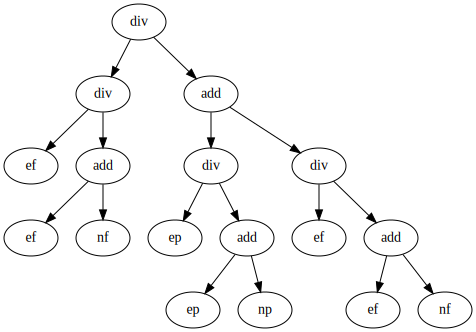

In [74]:
tarantula = Node(div,
                 Node(div, Node('ef'), Node(add, Node('ef'), Node('nf'))),
                 Node(add, Node(div, Node('ep'), Node(add, Node('ep'), Node('np'))),
                           Node(div, Node('ef'), Node(add, Node('ef'), Node('nf'))))
                )
print_tree(tarantula)

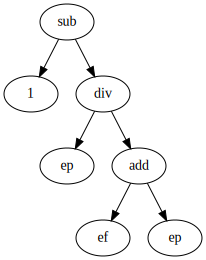

In [75]:
barinel = Node(sub, Node(1), Node(div, Node('ep'), Node(add, Node('ef'), Node('ep'))))
print_tree(barinel)

Barinel should perform better than Tarantula:

In [76]:
get_fitness(tarantula)

13.625

In [77]:
get_fitness(barinel)

6.625

But can we do better?

In [78]:
max_iterations = 100
population_size = 50
selection = tournament_selection
crossover = sizefair_crossover
P_xover = 0.7
fitness_values = []
size_values = []
result = ga()

GA Iteration 0, best fitness: 7.875, average size: 9.5
GA Iteration 1, best fitness: 7.875, average size: 8.333333333333334
GA Iteration 2, best fitness: 5.375, average size: 7.333333333333333
GA Iteration 3, best fitness: 2.625, average size: 6.583333333333333
GA Iteration 4, best fitness: 2.5, average size: 6.083333333333333
GA Iteration 5, best fitness: 2.5, average size: 5.5
GA Iteration 6, best fitness: 2.5, average size: 5.291666666666667
GA Iteration 7, best fitness: 2.5, average size: 5
GA Iteration 8, best fitness: 2.5, average size: 5.375
GA Iteration 9, best fitness: 2.5, average size: 4.625
GA Iteration 10, best fitness: 2.5, average size: 4.833333333333333
GA Iteration 11, best fitness: 2.5, average size: 5.291666666666667
GA Iteration 12, best fitness: 2.5, average size: 4.75
GA Iteration 13, best fitness: 2.5, average size: 4.25
GA Iteration 14, best fitness: 2.5, average size: 4.625
GA Iteration 15, best fitness: 2.5, average size: 4.833333333333333
GA Iteration 16, bes

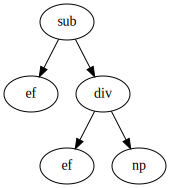

In [79]:
print_tree(result)

In [80]:
get_fitness(result)

2.5

Let's now compare the results of the standard metrics and our new one by looking at the top 5 most suspicious statements for each of the coefficients:

In [81]:
print_ranking(tarantula)

Faulty line: 7: (7, 17, 11, 6, 8)
Faulty line: 13: (6, 7, 8, 13, 18)
Faulty line: 39: (38, 39, 40, 42, 23)
Faulty line: 10: (9, 11, 12, 46, 48)


In [82]:
print_ranking(barinel)

Faulty line: 7: (7, 11, 6, 8, 9)
Faulty line: 13: (13, 0, 1, 2, 3)
Faulty line: 39: (38, 39, 40, 42, 23)
Faulty line: 10: (9, 72, 70, 71, 63)


In [83]:
print_ranking(result)

Faulty line: 7: (7, 6, 8, 11, 10)
Faulty line: 13: (13, 0, 1, 2, 3)
Faulty line: 39: (38, 39, 40, 23, 24)
Faulty line: 10: (9, 6, 7, 8, 10)


## Strongly-Typed Genetic Programming and Grammatical Evolution

Our implementation of GP is untyped, and thus requires type closure. Sometimes, depending on the problem to be solved, this can be an issue. In _strongly-typed genetic programming_ all nodes have types, and operators need to follow the type rules.

A common way to implement strongly-typed genetic programming is using _Grammar-Guided Genetic Programming (G3P)_: G3P is based on a grammar that describes the syntax of the target language.  Each individual of the population is a derivation tree of that grammer. (Derivation step = The process of replacing a nonterminal symbol with the symbols on the right-hand side of a production rule). G3P, in principle, works similar to our GP above, with the additional caveat that initialisation, crossover, and mutation need to be adapted in order to use the grammar and to ensure that only grammatically valid derivation trees are used.

An alternative way to use a grammar for evolution is using _Grammatical Evolution_ (GE): Whereas a classic GP uses syntax trees as representation, the representation in grammatical evolution is a simple linear genome. Each individual is a linear structure of codons (numbers) that select production rules to be chosen during derivation from a given grammar. 
Grammatical evolution clearly separates the search and solution spaces; syntactic correctness is guaranteed by the translation process; the problem of closure is removed, and any search algorithm can be used.

Since we are using a list representation, we will use our list helper class that can cache fitness values again:

In [84]:
class L(list):
    """
    A subclass of list that can accept additional attributes.
    Should be able to be used just like a regular list.
    """
    def __new__(self, *args, **kwargs):
        return super(L, self).__new__(self, args, kwargs)

    def __init__(self, *args, **kwargs):
        if len(args) == 1 and hasattr(args[0], '__iter__'):
            list.__init__(self, args[0])
        else:
            list.__init__(self, args)
        self.__dict__.update(kwargs)

    def __call__(self, **kwargs):
        self.__dict__.update(kwargs)
        return self

In GE the chromosome size is fixed. For example, let's start by setting the number of codons to 50. Each codon is a number in a given range, which we will encode using `MAX`:

In [85]:
num_codons = 50
MAX = 50

Individuals are simply lists of (randomly generated) codons:

In [86]:
def get_random_individual():
    individual = L([random.randint(0, MAX) for _ in range(num_codons)])
    evaluate(individual)
    return individual

This, in turn, means we can use our usual approach for mutating each gene in a chromosome with a probability dependent on the overall number of genes:

In [87]:
def mutate(individual):
    P_mutate = 1/len(individual)
    mutated = L(individual[:])
    for pos in range(len(individual)):
        if random.random() > P_mutate:
            mutated[pos] = random.randint(0, MAX)
    evaluate(mutated)
    return mutated

We can use standard crossover operators:

In [88]:
def singlepoint_crossover(parent1, parent2):
    pos = random.randint(0, len(parent1))
    offspring1 = L(parent1[:pos] + parent2[pos:])
    offspring2 = L(parent2[:pos] + parent1[pos:])
    return (offspring1, offspring2)

...and we can also use standard parent and survivor selection operators:

In [89]:
elite_size = 2
def elitism(population):
    population.sort(key=lambda k: get_fitness(k))
    return population[:elite_size]

In [90]:
tournament_size = 3
def tournament_selection(population):
    candidates = random.sample(population, tournament_size)        
    winner = min(candidates, key=lambda x: get_fitness(x))
    return winner

In order to explain the process of decoding codons to production rules, we need to define a grammar for an example problem. Let's assume we want to generate Python code for a function with two parameters, which returns the larger of the two parameters. Our grammar thus covers linear sequences of code with if-statements, where we restrict each if-statement to a single operation. Operations can be updates of a local variable `__return__` which, at the end of the function, will define the return value:

In [91]:
EXAMPLE_GRAMMAR = {
    "<start>":
        ["<code>"],

    "<code>":
        ["<line>", "<code>\n<line>"],

    "<line>":
        ["    <expr>"],

    "<expr>":
        ["<if-statement>",
         "<op>"],

    "<if-statement>":
        ["if <condition>:\n        <op>"],

    "<condition>":
        ["<param> <operator> <param>"],
    "<param>":
        ["x", "y"],
    "<operator>":
        ["<", ">", "=="],
    "<op>":
        ["__return__ = x", "__return__ = y"]
}

One of the production rules must be explicitly chosen as the start label"

In [92]:
START_SYMBOL = "<start>"

In order to determine whether a production rule contains further non-terminals we use a simple regular expression. Anything within `<` and `>` counts as a non-terminal:

In [93]:
RE_NONTERMINAL = re.compile(r'(<[^<> ]*>)')

In [94]:
def nonterminals(expansion):
    return re.findall(RE_NONTERMINAL, expansion)

Depending on the grammar used, a derivation can be of any size; we need to put some limit on the size of the derivations:

In [95]:
max_expansions = 50

In order to decode an individual we start with the start rule, and apply derivation. Whenever there is a choice of multiple production rules during the derivation, the number of the rule is determined by the next codon; i.e., we always pick the rule with the number _codon_ $%$ _number of rules_. Non-terminals are resolved from left to right (we need to make sure that the derivation is deterministic). Whenever we use a codon, we move to the next number in the chromosome. If we hit the last codon in a chromosome then we wrap and start over from the first one.

In [96]:
def decode(individual, grammar, log=False):
    pos = 0
    term = START_SYMBOL
    num_expansions = 0
    count = 0
    
    while len(nonterminals(term)) > 0 and num_expansions < max_expansions:
        
        symbol_to_expand = nonterminals(term)[0]
        expansions = grammar[symbol_to_expand]
        if len(expansions) == 1:
            expansion = expansions[0]
        else:
            codon = individual[pos]
            pos = (pos + 1) % len(individual)
            expansion = expansions[codon % len(expansions)]
            
        new_term = term.replace(symbol_to_expand, expansion, 1)
    
        term = new_term
        if log:
            print("%-40s" % (symbol_to_expand + " -> " + expansion), term)
        num_expansions += 1

    return term

In [97]:
decode([1,2,3], EXAMPLE_GRAMMAR, log=True)

<start> -> <code>                        <code>
<code> -> <code>
<line>                  <code>
<line>
<code> -> <line>                         <line>
<line>
<line> ->     <expr>                         <expr>
<line>
<expr> -> <op>                               <op>
<line>
<op> -> __return__ = y                       __return__ = y
<line>
<line> ->     <expr>                         __return__ = y
    <expr>
<expr> -> <if-statement>                     __return__ = y
    <if-statement>
<if-statement> -> if <condition>:
        <op>     __return__ = y
    if <condition>:
        <op>
<condition> -> <param> <operator> <param>     __return__ = y
    if <param> <operator> <param>:
        <op>
<param> -> y                                 __return__ = y
    if y <operator> <param>:
        <op>
<operator> -> >                              __return__ = y
    if y > <param>:
        <op>
<param> -> x                                 __return__ = y
    if y > x:
        <op>
<op> -> __return__ 

'    __return__ = y\n    if y > x:\n        __return__ = y'

Given the string representation of a program we need to create an executable version in order to measure the fitness. We already compiled code at runtime in the previous chapter, so we essentially do the same again here. For any given string representation of a function, e.g.:

In [98]:
text = """
def foo():
  print("Foo")
"""

We call the `compile` function which produces a code object. This code object we insert into the dictionary of modules such that we can call the function using its name, e.g.:

In [99]:
code = compile(text, filename="<GE>", mode="exec")
current_module = sys.modules[__name__]
exec(code, current_module.__dict__)

In [100]:
foo()

Foo


We use a function that puts the decoded chromosome into a function, and we'll include the function signature and return value for now:

In [101]:
def create_function(individual):
    program_text = decode(individual, EXAMPLE_GRAMMAR)
    source = """def generated_function(x, y):
    __return__ = 0
%s
    return __return__
""" % program_text
    code = compile(source, filename="<GE>", mode="exec")
    current_module = sys.modules[__name__]
    exec(code, current_module.__dict__)
    return generated_function

In order to calculate the fitness value we just need to run the function a number of times with some test data that represents the function we want to learn. Let's produce some test data again; let our example function return the maximum of the two input parameters:

In [102]:
training_data = []

In [103]:
for i in range(20):
    num1 = random.randint(0, MAX)
    num2 = random.randint(0, MAX)
    training_data.append(([num1, num2], max([num1, num2])))

There may be errors during the execution; for example, if we hit the maximum number of expansions (`max_expansions`) then the code may not compile. There may be an exception if there is a division by zero or some other error. In these cases we assign the function the maximum (worst) fitness value and let selective pressure handle this for us:

In [104]:
def evaluate(individual):
    fitness = len(training_data)
    individual.fitness = fitness
    try:
        p = create_function(individual)

        for (test_data, test_output) in training_data:
            result = p(*test_data)
            if result == test_output:
                fitness -= 1
    except:
        return len(training_data)

    individual.fitness = fitness
    return fitness

In [105]:
x = get_random_individual()
x.fitness

13

Since we call the `evaluate` function directly after generating or mutating individuals, retrieving the fitness function just consists of retrieving the cached fitness value:

In [106]:
def get_fitness(individual):
    return individual.fitness

In order to use our new individuals we need to modify our GA such that it uses this new representation rather than the tree structure we defined earlier; that is, we need to replace the ramped half and half initialisation with a simple random sampling:

In [107]:
def get_initial_population():
    return [get_random_individual() for _ in range(population_size)]

Furthermore, since we now have a fixed size representation we can omit the handling of size as a secondary criterion during selection:

In [108]:
def evolution_step(population):
    new_population = []
    while len(new_population) < len(population):
        parent1 = selection(population)
        parent2 = selection(population)

        if random.random() < P_xover:
            offspring1, offspring2 = crossover(parent1, parent2)
        else:
            offspring1, offspring2 = parent1, parent2

        offspring1 = mutate(offspring1)
        offspring2 = mutate(offspring2)
        
        new_population.append(offspring1)
        new_population.append(offspring2)

    population.clear()
    population.extend(new_population)

In [109]:
def ga():
    population = get_initial_population()
    best_fitness = sys.maxsize
    for p in population:
        fitness = get_fitness(p)
        if fitness < best_fitness:
            best_fitness = fitness
            best_solution = L(p[:])

    iteration = 0
    print(f"GA Iteration {iteration}, best fitness: {best_fitness}")
    while iteration < max_iterations and best_fitness > 0:
        fitness_values.append(best_fitness)
        iteration += 1
        evolution_step(population)

        for p in population:
            fitness = get_fitness(p)
            if fitness < best_fitness:
                print(f"GA Iteration {iteration}, best fitness: {best_fitness}")
                best_fitness = fitness
                best_solution = L(p[:])

    print(f"GA solution after {iteration} iterations, best fitness: {best_fitness}")
    return best_solution


With this, we can apply the grammatical evolution to produce our own max function:

In [110]:
population_size = 20
P_xover = 0.7
max_iterations = 100
num_codons = 20
selection = tournament_selection
crossover = singlepoint_crossover
fitness_values = []
result = ga()

GA Iteration 0, best fitness: 7
GA Iteration 4, best fitness: 7
GA solution after 4 iterations, best fitness: 0


In [111]:
print(decode(result, EXAMPLE_GRAMMAR))

    __return__ = x
    if y > x:
        __return__ = y


This problem is probably slightly too easy, so let's increase difficulty by expanding to three parameters. We therefore require a corresponding function template:

In [112]:
def create_function(individual):
    program_text = decode(individual, EXAMPLE_GRAMMAR)
    source = """def generated_function(x, y, z):
    __return__ = 0
%s
    return __return__
""" % program_text
    code = compile(source, filename="<GE>", mode="exec")
    current_module = sys.modules[__name__]
    exec(code, current_module.__dict__)
    return generated_function

As well as some test data:

In [113]:
training_data = []
for i in range(1000):
    num1 = random.randint(0, MAX)
    num2 = random.randint(0, MAX)
    num3 = random.randint(0, MAX)
    
    training_data.append(([num1, num2, num3], max([num1, num2, num3])))

We'll slightly expand our grammar to also include conjunctions and disjuctions and more relational operators:

In [114]:
EXAMPLE_GRAMMAR = {
    "<start>":
        ["<code>"],

    "<code>":
        ["<line>", "<code>\n<line>"],

    "<line>":
        ["    <expr>"],

    "<expr>":
        ["<if-statement>",
         "<op>"],

    "<if-statement>":
        ["if <condition>:\n        <op>"],

    "<condition>":
        ["<param> <operator> <param>", "<param> <operator> <param> and <param> <operator> <param>", "<param> <operator> <param> or <param> <operator> <param>"],

    "<param>":
        ["x", "y", "z", "__return__"],

    "<operator>":
        ["<", ">", "<=", ">=", "==", "!="],

    "<op>":
        ["__return__ = <param>"]
}

In [115]:
population_size = 100
P_xover = 0.7
max_iterations = 500
max_expansions = 80
num_codons = 80
selection = tournament_selection
tournament_size = 4
crossover = singlepoint_crossover
fitness_values = []
result = ga()

GA Iteration 0, best fitness: 499
GA Iteration 2, best fitness: 499
GA Iteration 3, best fitness: 490
GA Iteration 5, best fitness: 478
GA Iteration 5, best fitness: 461
GA Iteration 6, best fitness: 352
GA Iteration 122, best fitness: 300
GA Iteration 128, best fitness: 292
GA solution after 128 iterations, best fitness: 0


In [116]:
print(decode(result, EXAMPLE_GRAMMAR))

    if z > z or z <= z:
        __return__ = z
    if y <= __return__ or z >= __return__:
        __return__ = y
    if __return__ < x:
        __return__ = x
    if y > y:
        __return__ = z
    if __return__ < z and y < z:
        __return__ = z


More practical information about Genetic Programming can be found in the free ebook [A Field Guide to Genetic Programming](http://www0.cs.ucl.ac.uk/staff/W.Langdon/ftp/papers/poli08_fieldguide.pdf)

The programs we tried to evolve in this chapter have all been comparatively tiny. Indeed GPs are not generally used to evolve large programs, as they cannot easily come up with complex system designs and architectures. While evolving large programs from scratch may currently not be possible, it is possible to improve existing programs. This is the aim of program repair and genetic improvement, which we will consider next in the course.